$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# Final Project: Clustering of Genomic Functional Elements

Jacob Edwards

## Summary

Determining the underlying structure of the genome from sequence data is a central issue in bioinformatics research. Functional elements, such as promoters, enhancers, protein-coding regions, splice sites, etc. determine the ultimate behavior of the genome and thus the phenotype of the individual. Understanding how these genomic elements interact is crucial to combating the genetic underpinnings of disease, as well as understanding the biological nature of the genome itself. As new functional elements are being continually discovered, and precise data on their sequence similarities are sparse, efficient unsupervised clustering algorithms that can detect distinct elements have immense potential to improve our knowledge of the foundational organization of the genome ([Yip et al. 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-205)).

In unsupervised data clustering tasks such as $k$-means clustering, a commonly reported weakness is the choice of an appropriate number of clusters for the algorithm to divide the data into. One possible solution is start with $k=1$ and iteratively increase $k$ until the data in each cluster fall into a Gaussian distribution ([Hamerly & Elkan 2003](http://papers.nips.cc/paper/2526-learning-the-k-in-k-means)). However, for very large and high-dimensional data sets such as whole-genome sequences, such an approach is computationally expensive ([Trosset 2008](http://www.iub.edu/~stat/files/TR/TR-08-03.pdf)). An alternative approach called Self-Organizing Maps (SOMs; [Kohonen 1982](http://link.springer.com/article/10.1007%2FBF00337288#page-1)) has been reported to have success in segmenting genomic sequences into clusters without defining their number <i>a priori</i>. ([Tamayo et al. 1999](http://www.pnas.org/content/96/6/2907.abstract)). Thus, SOMs may be a better algorithm for such an endeavor in exploratory data analysis.

In this `Notebook`, I'll be exploring the potential of Self-Organizing Maps and $k$-means clustering algorithms to divide genomic data into related segments based on sequence similarity, in the effort to identify putative elements responsible for functional genomic behaviors.

## Introduction

### The Data

With advances in genomic sequencing technology over the past few decades, whole genomes of a diversity of organisms are available for public download. The [National Center for Biotechnology Information](http://www.ncbi.nlm.nih.gov/) hosts terabytes worth of sequence data, submitted by laboratories located across the globe. The [NCBI GenBank FTP](ftp://www.ncbi.nlm.nih.gov/genbank/) database is a treasure trove of sequence data from organisms spanning the tremendous diversity of life, from bacteria and fungi, to plants and animals; humans included. Depending on what has been submitted, data for a given species may consist of ordered chromosomal sequences, unordered whole-genome sequences, RNA transcript sequences, predicted gene sequences, epigenetic data, and more.

There is no shortage of data needed to understand the fundamental language of biology, <i>i.e.</i>, the DNA sequence. Our greatest challenge is how to interpret the language. The organism is a product of the interaction of these sequences. It is the novel; each individual nucleotide is barely a letter. Clearly, in order to understand the information that gives order to the biological organism, we must understand not only the alphabet, the syntax, and the grammar, but how these pieces of the language fit together into a unified whole. 

The first step in this endeavor is to detect "words" from the DNA letters, then on to concepts from combinations of words. The general approach of this `Notebook` will be to take a guess at the number of nucleotides required for a basic word, and will assume that all words are of such length (or a multiple of that constant). I'll address this assumption after discussing the algorithms used.

In this `Notebook`, I've included a short chunk (~the first 245,000 nucleotides) of the killer whale - *Orcinus orca* - genome, which is available in the .tar file. If this doesn't work or produces an error, you can uncomment and run the next cell to download and parse the file. This segment of the orca genome will be our workhorse for developing the algorithms. Later, we'll compare with other species.

In [2]:
## Uncomment to download Orca genome, taking only first 245k bases
# !wget ftp://ftp.ncbi.nih.gov/genomes/Orcinus_orca/CHR_Un/oor_ref_Oorc_1.1_chrUn.fa.gz
# !gunzip oor_ref_Oorc_1.1_chrUn.fa.gz
# !head -3500 oor_ref_Oorc_1.1_chrUn.fa > orcaSmall.txt
# !rm oor_ref_Oorc_1.1_chrUn.fa

First, we need to define some methods to handle the data and return some info about it. Let's begin by setting up the environment.

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import time  # for sleep

The below methods provide some basic functionality for reading in DNA sequence data from the NCBI's FASTA format. The file is just a header consisting of a unique sample identifier, then the sequence of nucleotides. The `loadSeq()` method expects only a single header per file, so if you want to deal with many sequences in a single file, you should separate them prior to sending them into `loadSeq()`.
* `loadSeq()`: Takes a FASTA-like file and generates a new `numpy` array consisting of `[0]`: The header data, typically including the species name and Accession #, and; `[1]` : the actual 1-dimensional sequence of `ATCGN` converted into digits `0-4`.
* `baseCount()`: Returns how many nucleotides are in the sequence, and how many of each there are in total. Generally, we expect the number of `A`'s to equal the number of `T`'s and likewise for `G`'s and `C`'s, but this is not always the case.
* `spName()`: Is useful for plotting. Returns the name of the species of the sequence given it has a proper header (accession number followed by genus and species name).

In [4]:
def loadSeq(filename,upper=True):
    ## Return a linear sequence as a list.
    ## First entry is GenBank Accession ID,
    ## Second entry is DNA sequence
    seqFile = open(filename,'r')
    seq = ['',[]]
    bases = {'A':0, 'T':1, 'C':2, 'G':3, 'N':4 }
    for line in seqFile:
        line = line.strip('\n')
        if line.startswith('>'): seq[0] = line
        else:
            line = list(line)
            seq[1].extend([bases[i.upper()] for i in line])
    print('Sequence loaded:')
    print(seq[0])
    print('Species: '+spName(seq))
    return seq

def baseCount(seq):
    ## Just to give a little extra info!
    seqLen = len(seq[1])
    if seqLen >= 1000000: print('Sequence length: '+str(round(seqLen/1000000))+' Mb')
    elif seqLen >= 1000: print('Sequence length: '+str(round(seqLen/1000))+' kb')
    else: print('Sequence length: '+str(seqLen)+' bp')
    print ('Nucleotide counts for '+spName(seq)+' ----')
    print('Amount A: '+str(seq[1].count(0)))
    print('Amount T: '+str(seq[1].count(1)))
    print('Amount C: '+str(seq[1].count(2)))
    print('Amount G: '+str(seq[1].count(3)))

def spName(seq):
    ## Return the name of the species given its full sequence file
    seqID = seq[0].split(' ')
    spName = seqID[1] + ' ' + seqID[2]
    return spName

As mentioned above, I'll be working with a "small" chunk of the *Orcinus orca* (killer whale) genome. If this file doesn't properly load, it will be necessary to uncomment and run the above cell to download from NCBI.

In [5]:
orca = loadSeq("orcaSmall.txt")
baseCount(orca)

Sequence loaded:
>gi|459977647|ref|NW_004438415.1| Orcinus orca isolate Morgan unplaced genomic scaffold, Oorc_1.1 Scaffold1, whole genome shotgun sequence
Species: Orcinus orca
Sequence length: 245 kb
Nucleotide counts for Orcinus orca ----
Amount A: 67675
Amount T: 65416
Amount C: 45896
Amount G: 43533


Just like the letters in languages that we write, our DNA "letters" are clustered in sequence non-randomly to convey complex ideas. The meaning, or function, of a given sequence of letters should be related to how often it occurs in the whole sequence. For instance, the word "and" has a distinct functional role in a sentence, and should be expected to occur often. It is a necessary word in our language! Analogously, DNA words, such as "`TATA`" have important roles in the language (`TATA` in particular is a polymerase binding site, critical for protein production). We might expect then, that the functionality of a DNA sequence is proportional to its frequency in the genome. This is a generous assumption, but it allows us to now divide the genome into manageable segments. We can now quantify the frequencies of each short sequence for every given position of the genome, making a "frequency map". The pattern of short sequences will give us insight into the distribution of functional elements and hopefully allow us to detect their presence.

These short sequences, such as `ATCC` or `GAAGACC` are called *oligonucleotides*. With the functions defined below, we can split the DNA into oligonucleotides and quantify how frequently that sequence occurs in the whole.

* `makeFreqData()` takes advantage of `numpy`'s structured arrays. In the first column of the array is the sequence detected, such as `ATTA` (if we pass in an oligonucleotide lenth of `4`), in the second is a count of how many times that sequence appears, and the last column stores an array of all the positions in the linear sequence in which that sequence occurs. It attempts to return an ordered array (with the most frequent sequences at the top), but on very large sequences (over 1 million bases), errors are generated by the sorting tool.

In [6]:
def makeFreqData(seq,stepCount=4,printTop=0):
    # Divides the sequence into chunks and returns frequency of each chunk
    init = 0
    intStart = []
    intStop = []
    bases = {0:'A', 1:'T', 2:'C', 3:'G', 4:'N' }
    numPos = len(seq[1])/stepCount
    
    # Initialize a structured array that contains as many entries as possible nucleotide combos
    # We'll chop off any unused ones at the end
    seqFreq = np.empty((5**stepCount,1), dtype=[('seq','S{}'.format(stepCount)),('freq',int),('pos',np.ndarray,(1))])
    
    # Divide the sequence into slices given by stepCount
    while init < len(seq[1]):
        intStart.append(init)
        init += stepCount
        intStop.append(init)
                       
    idxCount = 0
    for step in range(len(intStart)): # For each chunk of sequence
        ## This first bit takes some chunk of sequence given by stepCount
        ## And converts it into a single string
        seqCurr = seq[1][intStart[step]:intStop[step]]
        seqString = []
        for i in seqCurr:
            seqString.append(bases[i])
        seqString = ''.join(seqString).encode('ascii') # np works with bytestrings
        
        ## For every chunk of sequence, keep track of how often it occurs, and its
        ## position on the read
        if not seqString in seqFreq['seq']: # make a new entry
            seqFreq[idxCount] = (seqString, 1, step)
            idxCount += 1 # step up index counter so next entry checks a blank slot
        else: # update an already existing entry with frequency and position
            idx = np.where(seqFreq['seq']==seqString)[0][0]
            seqFreq[idx]['freq'] += 1 #/ numPos #<---- uncomment and add below to conv to freqs
            seqFreq[idx]['pos'][0] = np.append(seqFreq[idx]['pos'][0], step)
            
    ## Verification that frequencies are correct
    # count = 0 #
    # for i in seqFreq:
    #     count += seqFreq[i]
    # print('sum of freqs: '+str(count))
    
    ## Chop off everything not used
    keepIdx = max(np.where(seqFreq['freq'] != 0)[0])#+1
    finalFreq = seqFreq[:keepIdx]
    
    ## Sort by descending frequency
    try:
        inds = finalFreq.argsort(order='freq', axis=0) # error here when step is big
        inds = inds[::-1]
        np.take(finalFreq, inds, out=finalFreq)
    except:
        print('WARNING: Could not sort')
    
    print('Sequence chunked into '+str(finalFreq.shape[0])+' unique oligonucleotides')
    if printTop != 0:
        for i in finalFreq[:printTop]:
            print('Seq: '+i['seq'][0].decode('ascii'),'| Freq: '+str(i['freq'][0]))
    
    return finalFreq

Let's make the frequency data for the orca sequence, chopped up into *tetranucleotides* (oligonucleotides of length 4).

In [7]:
orcaFreqs = makeFreqData(orca,4,printTop=10)

Sequence chunked into 265 unique oligonucleotides
Seq: NNNN | Freq: 5597
Seq: AAAA | Freq: 895
Seq: TTTT | Freq: 860
Seq: AAAT | Freq: 591
Seq: ATTT | Freq: 552
Seq: TAAA | Freq: 538
Seq: AATA | Freq: 483
Seq: GAAA | Freq: 467
Seq: CAAA | Freq: 466
Seq: AAGA | Freq: 461


It looks like the sequence of repeat `N`'s is the most common by an order of magnitude. The `N` means any base; `ATC` or `G` can go there, so this doesn't really help our cause!

For now though, we have a table which we can use to "reconstruct" the chromosome, but now as a band of counts, where each position on the chromosome is colored by how often that sequence is found.

* `freqToSeq()`, will return a 1 x *n* row vector of oligonucleotide frequencies for *n* positions in the genome, essentially unraveling the table of frequency data made above.

This "band" of frequencies will turn out to be a useful way to visualize the data. We can think of the genome as being a band of frequencies, like a voice speaking a sentence, that contains meaningful information and can be broken down into repeatable components. It is modular and has an underlying structure.

In [8]:
def freqToSeq(seq,freqList,noRepeat=True):
    seqLen = len(seq[1]) / len(freqList['seq'][0][0])
    seqLen = int(seqLen)
    
    F = np.zeros((seqLen,1))
    for sequence in freqList:
        freqVal = sequence['freq'][0]
        if noRepeat:
            if sequence['seq'][0] == b'N'*len(sequence['seq'][0]):
                freqVal = 0 ## I set 'N' nucleotide repeats to 0 so they don't swamp out means
        posList = sequence['pos'][0]
        if type(posList) == np.ndarray:
            for pos in posList:
                F[pos][0] = freqVal
        else:
            F[posList][0] = freqVal
    F = F.T
    return F

* `plotFreq()` will simply plot a band of frequencies for us. We can see the total number of oligonucleotide positions by sending a `True` value into the `printPos` parameter. It makes the frequency band within the function, which will be useful for selecting certain features to plot.

In [9]:
def plotFreq(seq,freqList,printPos=False,noRepeat=True):
    freqPlot = freqToSeq(seq,freqList,noRepeat)

    plt.figure(figsize=(18,2))
    plt.imshow(freqPlot, cmap='magma', interpolation='nearest', aspect='auto')
    ax = plt.axes()
    ax.axes.get_yaxis().set_visible(False)
    plt.xlabel('position', fontsize=12)
    plt.title(spName(seq),fontsize=18,loc='left')
    if printPos:
        print(str(freqPlot.shape[1])+' positions')

Finally, let's see what this genome looks like!

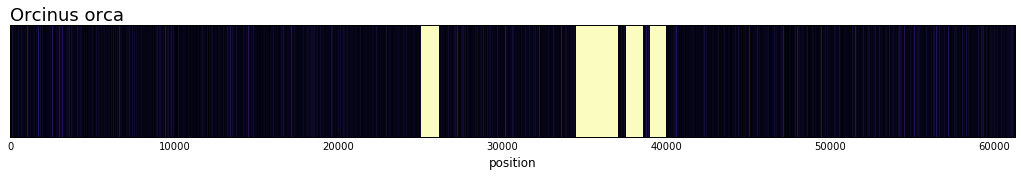

In [10]:
plotFreq(orca,orcaFreqs,noRepeat=False)

Should have seen this coming! If we recall, the number of `N`-nucleotide repeats totally swamps out the influence of everything else we care about. Those are definitely the bright yellow-white bands. If you squint, you can see faint bluish banding scattered throughout.

However, if we successfully ordered our initial frequency table, it should be easy to exclude these sequences from the plot.

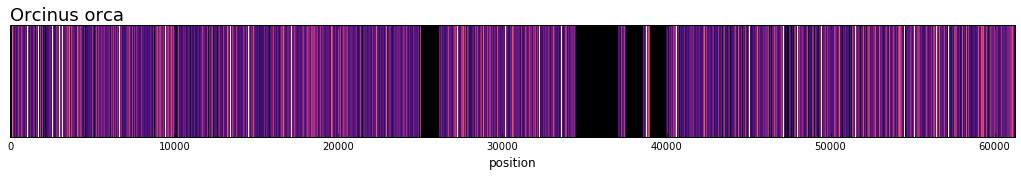

In [11]:
plotFreq(orca,orcaFreqs)

Wow! Much better detail. Conveniently, these highly variable regions are "blacked-out". Notice how they mirror the pattern above. It's worth remembering again that the intensity of the band at a given position is the *frequency* of that oligonucleotide (`TTAC`, for example) in the sequence overall; so it is independent of what those letters actually are. Are there any patterns here? It does seem that more frequent elements are are grouped together more often. Look at just before position 10,000 -- there seems to be an area of high frequency there. Likewise, at position 20,000 and just before there seems to be a small peak, a drop, and another small peak.

Now that we have a genetic sequence loaded up and formatted in a meaningful, plottable way, let's apply some unsupervised machine learning algorithms in an attempt to uncover patterns in these bands of frequencies. Again, we are working under the assumption that more important functional elements will occur more often together than random. Granted that, we should be able to estimate an underlying structure to the data!

## Methods

### Detecting Functional Genomic Elements with Clustering Algorithms

The genomes of organisms are tremendously complex beasts. Biologists are uncovering functional elements, *i.e.* sequences that *do things*, at a good pace but ultimately, given the availability of genomic sequence data, it would be ideal to develop tools to predict the locations of such elements automatically. This labelling of sequences by their function is called "annotation", and unfortunately requires time- and money-consuming laboratory work by human investigators. As such, the amount of raw sequence data vastly outstrips the availability of annotated sequences. On top of this, no biologist would agree that we have discovered all types functional elements in the genome. 

Because of such constraints, supervised training algorithms today are not a realistic option for predicting genomic function from sequence. Many aspects of genomics research are still in the exploratory phase, thus unsupervised clustering methods may be our best tool for guiding future research. By developing such tools to predict where functional elements might be located, scientists will be better informed as to where to direct their investigation. If clustering algorithms predict functional elements in previously unassuming locations, then this could open rich avenues for discovery.

We'll continue working with the truncated orca genome to develop two tools for clustering analysis, then expand into other species and applications once the algorithms have been demonstrated.

### K-means clustering algorithm

$K$-means clustering is one of the most common unsupervised learning methods when approaching datasets with unknown structure. We know that the genome contains an underlying structure hidden in the sequence of nucleotides. How well can $k$-means handle this problem? I'll adapt the implementation provided in class to work with our genomic data.

The goal of $k$-means is to detect natural groupings of the data. The number of groups to divide the data into, $k$, must be decided beforehand. To begin, we initialize a set of $k$ cluster centers positioned randomly throughout the data space. Here, we randomly grab a position on the sequence and choose the frequency value corresponding to that. While other approaches might be better, for this data it seemed to work nicely. Cluster centers are initially spread more or less evenly througout the sequence.

After initializing we begin the main loop, iterating through $N$ times. For each data point $\xv_n$, we assign that point to a group determined by its closest cluster center. Then, for each group, we calculate $E$, called the "reconstruction error", or the sum of differences between each cluster center and the mean of its data. $E$ is the function we are attempting to optimize. We define it as follows:

$$
E = \sum_{n=1}^N \sum_{k=1}^K b_{nk} ||\mathbf{x}_n - \mathbf{\mu}_k||^2
$$

So, for every cluster $k$ in the set of $K$ clusters, we calculate the squared difference between all the data points $\xv_n$ and the mean of the cluster $\mathbf{\mu}_k$. The $b_{nk}$ term determines whether or not a data point located at position $n$ is in that group. We calculate it as follows:

$$
b_{nk} = \begin{cases}
1,& \text{if } ||\mathbf{x}_n - \mathbf{\mu}_k|| < \min_j ||\mathbf{x}_n - \mathbf{\mu}_j||\\
0, & \text{otherwise}
\end{cases}
$$

So, if $\xv_n$ is not in in the cluster $k$ we are looking at, then its $b_{nk}$ is 0 and therefore doesn't contribute to the summation!

Finally, we update the position of each cluster center by moving it to the mean of all its members.

Some implementations of this algorithm wait until cluster centers no longer change in order to terminate. In this implementation, we iterate through $N$ times. I found that 15-20 iterations is more than enough for $E$ to level off (and thus cluster centers stop moving).

* `calcE()` calculates the reconstruction error as defined above. It is only used within `kmeans()`.
* `kmeans()` is the implementation of the $k$-means algorithm with parameters for the number of groups $k$ and the number of iterations $n$. It will also plot the time series of the moving cluster centers and error curve. This plotting is computationally expensive -- even for our shortened orca genome it takes some time. For larger datasets it may not be advisable to do dynamic plotting. I have provided a static band plot method for $k$-means output (like those above) to make comparisons easier.

In [12]:
def calcE(data,centers):
    diffsq = (centers[:,np.newaxis,:] - data)**2
    return np.sum(np.min(np.sum(diffsq,axis=2), axis=0))

def kmeans(data, k = 2, n = 5, plot=False):
    
    # I make the data 2-d, adding the position as an explicit column
    data = np.hstack((np.arange(data.shape[1]).reshape(-1,1),data.T))
    
    if plot:
        fig = plt.figure(figsize=(18,8))
        
    def drawit():
        plt.clf()
        plt.subplot(3,1,1)
        plt.plot(E)
        plt.subplot2grid((3,1), (1, 0), rowspan=2)
        plt.scatter(data[:,0], data[:,1], s=80, c=closest, alpha=0.01)
        plt.scatter(centers[:,0],centers[:,1],marker='D',s=100,c="green",alpha=0.5)
        plt.xlim([0,closest.size])
        ipd.clear_output(wait=True)
        ipd.display(fig)
        time.sleep(1)
    
    # Initialize centers and list E to track performance metric
    centers = data[np.random.choice(range(data.shape[0]),k,replace=False), :]
    E = []
    
    # Repeat n times
    for iteration in range(n):
        
        # Which center is each sample closest to?
        sqdistances = np.sum((centers[:,np.newaxis,:] - data)**2, axis=2)
        closest = np.argmin(sqdistances, axis=0)
        
        # Calculate E and append to list E
        E.append(calcE(data,centers))
        
        if plot:
            drawit()
        
        # Update cluster centers
        for i in range(k):
            # print(np.sum(closest==i))
            centers[i,:] = data[closest==i,:].mean(axis=0)
            
    # Calculate E one final time and return results
    E.append(calcE(data,centers))
    if plot:
        drawit()
        ipd.clear_output(wait=True)
        
    return centers,E,closest

* `kMeansBandPlot()` takes in the output of `kmeans()`, specifically the list of `closest` values, and plots them on a band like those shown above. These bands are the same size as the frequency bands, so we can compare them side-by-side to see just how the algorithm clusters the data!

In [13]:
def kMeansBandPlot(freqBand,nMeans,sp):
    plt.figure(figsize=(18,2))
    plt.imshow(closest.reshape(1,-1), cmap='gist_stern', interpolation='nearest', aspect='auto')
    ax = plt.axes()
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params('both', length=-3, width=1, which='major')
    plt.xlabel('position', fontsize=12)
    plt.title(spName(sp)+', functional groups by {}-means'.format(nMeans),fontsize=18,loc='left')

OK, let's apply $k$-means to the orca genome and see what happens! We know there are probably a lot of groups here, so lets start with 20-means at 15 iterations. First, we need to convert our table of frequencies into a 1D band of frequences. `kmeans()` will make it essentially 2D by explicitly attaching a coordinate value to each frequency.

In [14]:
orcaBand = freqToSeq(orca,orcaFreqs)
orcaBand.shape

(1, 61232)

Now we can send that band into `kmeans()` and get to work.

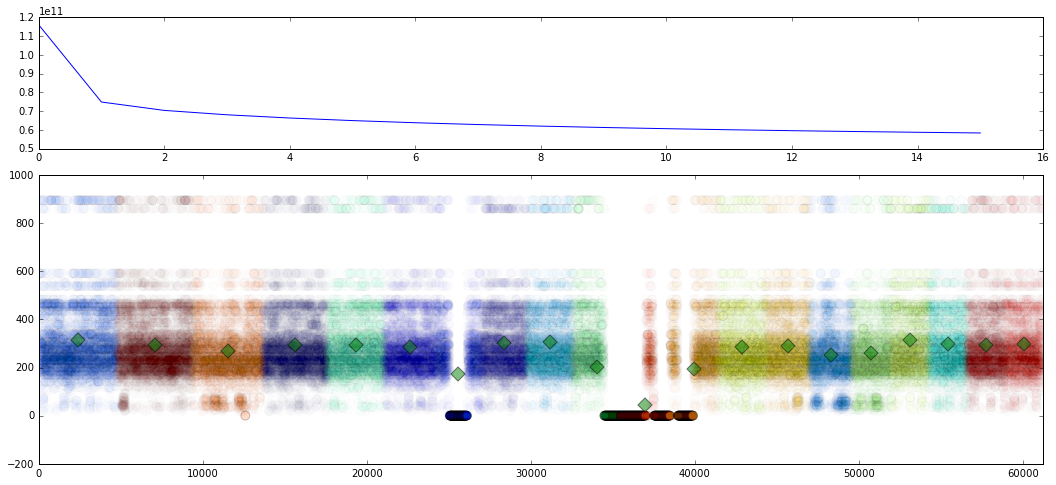

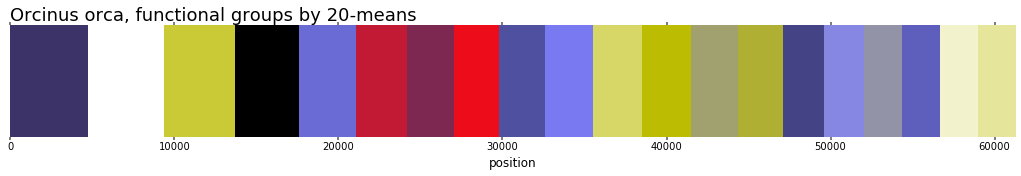

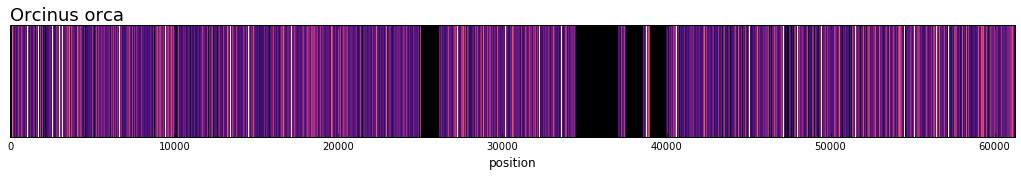

In [15]:
c,E,closest = kmeans(orcaBand,20,n=15,plot=True)
kMeansBandPlot(closest,20,orca)
plotFreq(orca,orcaFreqs[1:])

Fascinating! Our error plateaus to below 1 very quickly; pretty good! Interestingly, a lot of our clusters are of similar width. This probably reflects some of the caveats of $k$-means that I'll discuss in a moment. But looking at the comparison to the original frequency band, it seems that it captures some of that frequency variation. Bands of high frequency seem to be located either at the center or the borders of the clusters.

Let's try another! Let's go crazy and see what 200-means looks like.

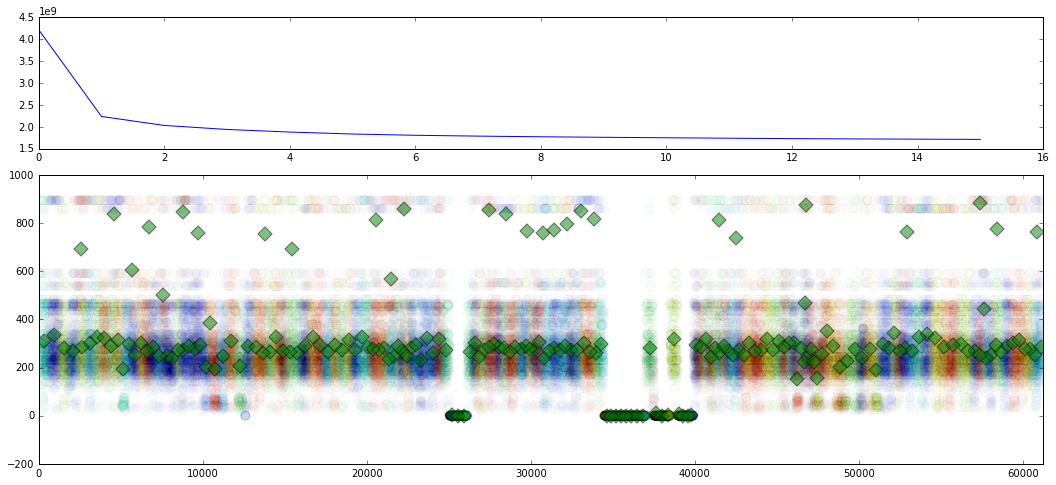

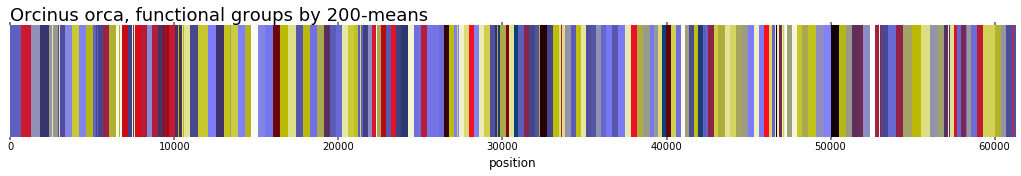

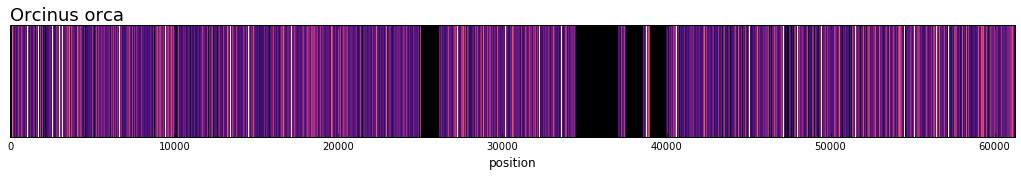

In [16]:
c,E,closest = kmeans(orcaBand,200,n=15,plot=True)
kMeansBandPlot(closest,200,orca)
plotFreq(orca,orcaFreqs[1:])

One of the interesting outcomes of this run was that with more cluster centers, many more of them moved up into the "cloud" layer of higher frequencies around 850-900, corresponding to the stronger peaks in the frequency band. We can see the effect of this in the functional group band, where the very narrow (almost pixel-wide) stripes correspond almost directly to the positions on the frequency band of high intensity. Our error didn't get as low as with 20-means, but stil leveled off around 6 iterations at about 1.8-2. One glaring issue is all the clustering happening in our "black box" of `N`-repeats! Perhaps without variation $k$-means is easily confused.

But is this truly reflective of the natural clumping of the data? It's hard to say. I will note two major drawbacks of using $k$-means in general that are particularly relevant here.
* First, $k$-means suffers from what is called "locality". That is, the initial, random selection of cluster centers strongly influences the final positions of those clusters. We saw this when $k$ was low -- the fairly even selection of random cluster centers resulted in clusters that ended up being more or less evenly spread.
* Second, no matter the natural number of clusters, by defining $k$ beforehand we force the algorithm to seek that many clusters, even if there are not that many (or there are many more). To illustrate my point, watch the animation below, which was the result of several iterations of the algorithm on this same data for a number of different $k$. We can see that by the time $k$ reaches 2,000, visual interpretation of the data becomes difficult. Is this truly an accurate reflection of the data's structure?

<img src="files/kMeans.gif">

What is the "correct" $k$ then? It seems to me that it depends on what scale you are asking! Do we want to break the genome down into genes? Or do we want to break genes down into coding and non-coding regions? A smaller $k$ might give us better results for the first situation, whereas a larger cluster number will detect (or force) finer-scale breakdown. It has been noted that the genome really is hierarchically ordered, with "clusters within clusters" ([Dios et al. 2014](http://www.sciencedirect.com/science/article/pii/S1476927114000905)). The size of $k$, then, should be decided based on the scale of the question being asked. Hierarchical clustering methods are probably better for this data, but that will have to be explored in another `Notebook`!

Given all this, $k$-means is by no account a useless approach for exploratory analysis. But some success has been reported for Self-Organizing Maps in clustering genomic data ([Yip et al. 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-205)), so let's see how that performs.

### Self Organizing Maps algorithm

Self Organizing Maps (SOMs), described by [Kohonen](http://link.springer.com/article/10.1007%2FBF00337288#page-1) are a simple type of neural network used in unsupervised learning. The key difference is a lack of backpropagation. Because target classes are unknown, there is no error to propagate back! Instead, each neural unit becomes "specialized" to respond to a particular input feature, and influences nearby units selectively. The advantage to this technique over $k$-means is that the number of classes or clusters does not need to be specified in advance. Here's how the algorithm works:

Much like our neural networks, for every training sample $\xv_1, \xv_2,... \xv_n$ in $\Xv$, we have a vector of weights $\wv_1, \wv_2,... \wv_n$ in each node of the self-organizing map. These weights transform the inputs to an output. We'll iniate them randomly, though there are other methods for weight initiation that won't be explored here.

Now, with our weights initiated, we'll simply loop through the following steps: First, pick a random sample from the training data. In this case, we pick a random position along the DNA, and send in its position coordinate as well as the oligonucleotide frequency associated with it. Once selected, we want to find the node in the SOM that has the best-matching weights to the given sample. The simplest way to do this is to calculate the Euclidean distance from the input to the node weights. So, for $k$ nodes:

$$
d_k = \sqrt{\sum_{i=0}^{n}(\xv_i-\wv_i)^2} \\
\\
\mathbf{D}=\begin{bmatrix}
    d_1 \\ d_2 \\ \vdots \\ d_k
\end{bmatrix} \\
\\
best = \argmin{\mathbf{D}}
$$

In SOMs, the best matching unit (or node) has an influence on nearby nodes in its *neighborhood*. Like neurons in the brain, the spiking of one cell can induce a spike, albeit of less intensity, in neighboring cells. We'll call the radius of this neighborhood to the best matching unit $\sigma$, and it will shrink over time; this is what allows for "specialization" in the network.

$$
\sigma_t = \sigma_0e^{\frac{-t}{\lambda}}
$$

For every node in the best matching unit's neighborhood, we can update the weights as follows:

$$
\wv_{t+1} = \wv_t + \sigma_t(\xv - \wv)
$$

Where $t$ is an iteration (or *epoch*) of of SOM training, so for $N$ iterations $t = 1,2,3,...t_N$

However, we don't want to adjust weights uniformly for each node in the neighborhood. It would be better for the strength of the weight adjustment to decrease as distance to the best matching unit increases. A Gaussian decay function will do the trick. We'll call this discount $\phi$ and define it as follows:

$$
\phi = e^{-\frac{dist^2}{2{\sigma_t}^2}}
$$

Of course, in order to *learn* anything we need the map to stabilize; we need nodes to eventually settle on their weights. We'll add a learning decay parameter that looks just like the rate at which we shrink the best matching unit's neighborhood. We can name it $\gamma$ and define it:

$$
\gamma_t = \gamma_0e^{\frac{-t}{\lambda}}
$$

Finally, then, we have a simple way to update a node's weight vector at each time step. For each node in the best matching unit's neighborhood, we update:

$$
\wv_{t+1} = \wv_t + \gamma_t\phi_t\sigma_t(\xv - \wv_t)
$$

Let's put it into Python.

In [17]:
def SOM(freqBand,nIterations,gamma,sigma=1,nNodes=10,plot=False):
    
    # I make the data 2-d, adding the position as an explicit column
    X = np.hstack((np.arange(freqBand.shape[1]).reshape(-1,1),freqBand.T))
    
    # Initialize the SOM with random weights
    #Som = np.random.randint(max(freqBand[0]), size=(nNodes,2))
    mapFrq = np.random.randint(max(freqBand[0]), size=(nNodes,1))
    mapPos = np.random.randint(freqBand.shape[1], size=(nNodes,1))
    Som = np.hstack((mapPos,mapFrq))
    
    # Initial params
    sigma = round(nNodes/5)
    gamma = gamma #/nIterations
    lamb = nIterations*100  # Bigger lambda, slower learning and influence area decay
    
    if plot:
        fig = plt.figure(figsize=(18,6))
    for i in range(nIterations):
        sample = X[np.random.choice(X.shape[0])] # Pick a random sequence chunk from X
        
        def drawit():
            plt.clf()
            #plt.plot(Som[:,1])
            plt.scatter(X[:,0],X[:,1],s=80,c="blue",alpha=0.1)
            plt.scatter(Som[:,0],Som[:,1],s=70,marker="s",c="red",alpha=0.5)
            plt.scatter(sample[0],sample[1],s=100,marker="s",c="lime")
            plt.xlim([0,X.shape[0]])
            ipd.clear_output(wait=True)
            ipd.display(fig)
            #time.sleep(0.0001)
        if plot:
            drawit()

        # Find the node in the SOM that best matches the input data
        distances = np.zeros((nNodes,1))
        for k in range(nNodes):
            distances[k] = np.sqrt(sum((sample-Som[k])**2)) 
        bestNode = np.argmin(distances)

        # Find the neighborhood of the bestNode - I'll represent linearly for now
        sigma = int(round( sigma * np.exp(-i/lamb) ))
        gamma = gamma * np.exp(-i/lamb)
        for j in range((bestNode-sigma),(bestNode+sigma)):
            if j > 0 and j < nNodes:
                dist = float(abs(j-bestNode))
                phi = np.exp( -(dist**2) / (2*(float(sigma)**2)) )
                Som[j] = Som[j] + gamma*phi*sigma*(sample-Som[j])
             
    if plot:
        drawit()
        ipd.clear_output(wait=True)
                
    print('SOM trained {} nodes for {} iterations.'.format(nNodes,nIterations))
    return Som

That's the whole algorithm, along with some functionality for plotting the action as it happens. Let's make one more function to draw where SOM places its nodes along our sequence.

* `SOMBandPlot()` takes the SOM, the sequence band that was used to make it (for reference), and the original sequence file (to get the species name for printing).

In [18]:
def SOMBandPlot(som,seqBand,sp):
    
    nodeBand = np.zeros((1,seqBand.shape[1]))
    for i in som:
        nodeBand[0][i[0]] = 1 #i[1] #<--- Uncomment to show intensity
    
    plt.figure(figsize=(18,2))
    plt.imshow(nodeBand, cmap='magma', interpolation='nearest', aspect='auto')
    ax = plt.axes()
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params('both', length=-3, width=1, which='major')
    plt.xlabel('position', fontsize=12)
    plt.title(spName(sp)+', Node placement by SOM', fontsize=18,loc='left')

To best way to understand how SOMs work is to watch one unfold. Unfortunately, even for this segment of the orca genome we have, plotting step by step is excruciatingly slow. Instead, we can watch the algorithm at work on an even smaller subset of our data.

In [19]:
smallBand = orcaBand[0][:1000].reshape(1,-1)

Let's watch a small SOM form. The red squares are the nodes in the network. They have a weight for the position coordinate along the sequence, and one for the frequency. The flashing green square is the random sample we are presenting to the network for that iteration.

SOM trained 50 nodes for 50 iterations.


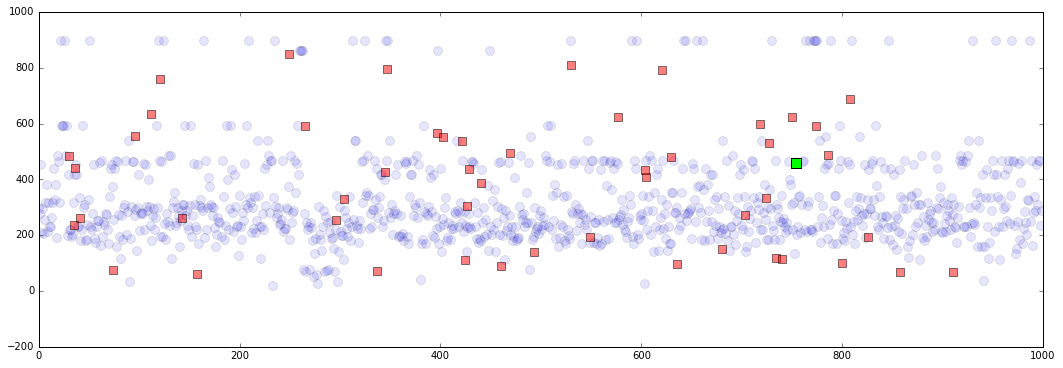

In [20]:
smap = SOM(smallBand,nNodes=50,nIterations=50,gamma=0.001,plot=True)

Very interesting, but I'm not convinced this algorithm is really finding much structure in our data! Before discussing further, let's see how these nodes might look plotted on a frequency band like we have been doing. Their locations should reveal where clusters lie. If there isn't any clustering, we should see an even spread both across the band. Instead of showing their frequency, here I am just plotting the position of the node. If nodes cluster, then we've found a pattern (well, maybe...)!

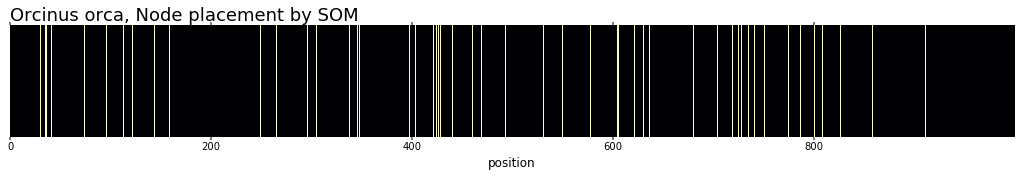

In [21]:
SOMBandPlot(smap,smallBand,orca)

Looks like that's just it. A pretty even spread of node positions. To make sure the algorithm is really capable of picking up patterns, let's add another segment to this data that is definitely clustered farther away.

SOM trained 50 nodes for 1000 iterations.


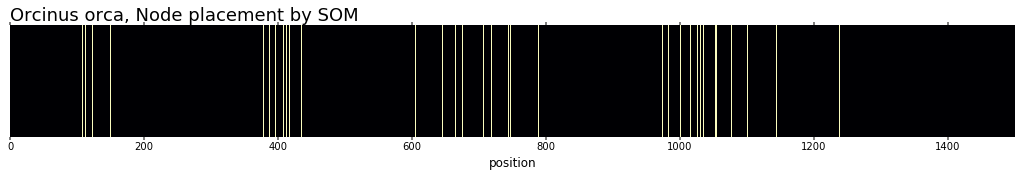

In [22]:
biggerBand = np.hstack((smallBand.reshape(1,-1), np.ones((1,500))*3000))
biggerMap = SOM(biggerBand,nNodes=50,nIterations=1000,gamma=0.01)
SOMBandPlot(biggerMap,biggerBand,orca)

Yep, that looks like some clustering to me. Notice the cluster around position 1200. Let's see how it looks on the sequence graph.

(0, 1500)

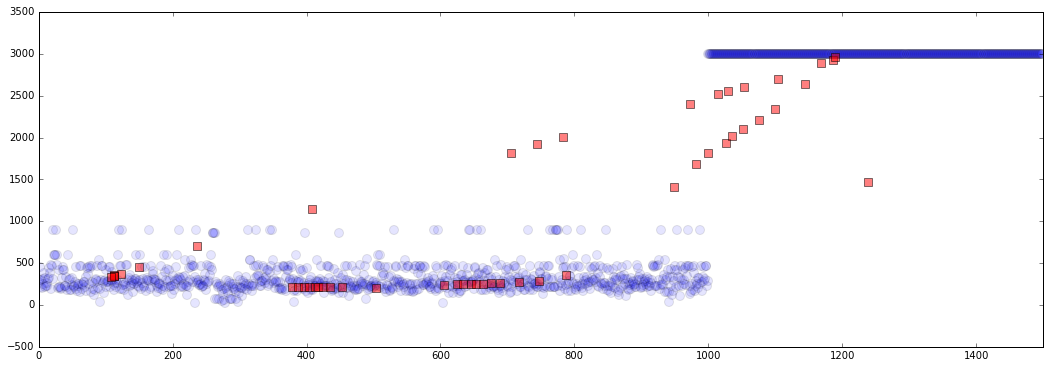

In [23]:
fig = plt.figure(figsize=(18,6))
plt.scatter(np.arange(biggerBand.shape[1]).reshape(1,-1),biggerBand[0,:],s=80,c="blue",alpha=0.1)
plt.scatter(biggerMap[:,0],biggerMap[:,1],s=70,marker="s",c="red",alpha=0.5)
plt.xlim([0,biggerBand.shape[1]])

Interesting, we are definitely getting a division right about where we would expect. It is interesting to note the spread of clusters on the actual DNA data as opposed to the tightness of my dummy data off to the right.

What really helped this one out was increasing the value of $\gamma$, or the rate at which learning decays. By starting it a bit higher, it made the nodes much more "sensitive", in a way, to movement. At very low $\gamma$, nodes shift positions sluggishly. It is fun to see the map form at higher $\gamma$; take a look below.

SOM trained 50 nodes for 50 iterations.


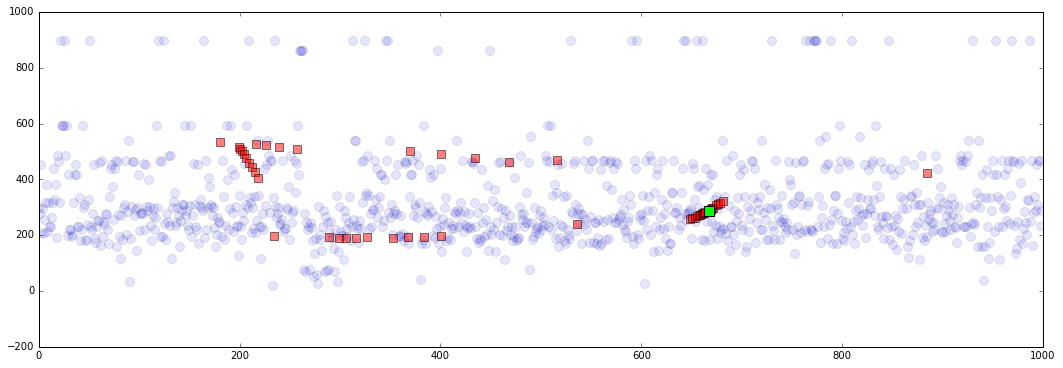

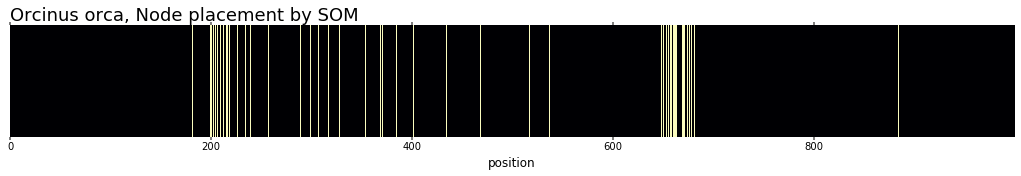

In [24]:
smap = SOM(smallBand,nNodes=50,nIterations=50,gamma=0.1,plot=True)
SOMBandPlot(smap,smallBand,orca)

It looks like allowing the nodes of the SOM to learn extremely rapidly and without decay creates the *illusion* of clusters on our band plot. Clearly a proper application of this algorithm relies on a delicate balance between the sizes of initial $\sigma$, $\gamma$, and $\lambda$. For now, though, I'll make some guesses as to parameters that might work. I believe the real problem may be in the way the data is structured.

On the grand scale, because of the sheer size of our genetic data, true clusters may be too tightly linked to local variation, whereas SOM is attempting to detect broader topologies. We might like to make a very large (as in, number of nodes) SOM, but even these seem to be insensitive to fine-scale variability. After playing with some parameters, it is not clear to me that this algorithm is good for this data. At least, in the way we have it structured by oligonucleotide frequency. Take a look below at a run of the algorithm. It seems often the case that the nodes are being pulled up by high-frequency positions, and down by low-frequency positions. The alternation between the two is so frequent that most nodes just settle on the mean, giving us a more or less straight line down the middle of the data.

<img src="files/final_output.gif">

Perhaps, as we will investigate below, segmenting the data into longer or shorter oligonucleotides will create more detectable patterns?

## Further Application and Comparison of Algorithms

Now that we have built $k$-means and SOMs to cluster genomic data, let's see how well they do! First, I'll compare their results on a few other species' genomes. Then, we'll investigate how selecting different oligonucleotide lengths affects their outcomes. Finally, as a real-world application, I'll apply the algorithms to a human gene where the locations of functional elements are known.

### Outcomes on other species

So far we've been just working with a short segment of the DNA for one organism - *Orcinus orca*. While perhaps we haven't completely clustered its genome, let's take a look at what our algorithms find for other species. Variety is the spice of life!

I've included the shortened sequence data for three species: *Hydra magnipapillata*, a freshwater polyp touted by some as being ["effectively immortal"](http://www.dailymail.co.uk/sciencetech/article-2521210/Freshwater-polyp-described-effectively-immortal-scientists.html), *Elaeis guineesnsis*, the [African oil palm](https://en.wikipedia.org/wiki/Elaeis_guineensis), an important economic plant, and *Pteropus vampyrus*, the ["large flying fox"](https://en.wikipedia.org/wiki/Large_flying_fox), AKA one of the largest bats in the world, AKA a [*mega*bat](https://en.wikipedia.org/wiki/Megabat). If for some reason the files won't load, you can download and truncate yourself by uncommenting and running the below commands.

In [25]:
# # HYDRA magnipapillata - a hydra
# !wget ftp://ftp.ncbi.nih.gov/genomes/Hydra_magnipapillata/CHR_Un/hma_ref_Hydra_RP_1.0_chrUn.fa.gz
# !gunzip hma_ref_Hydra_RP_1.0_chrUn.fa.gz
# !head -10000 hma_ref_Hydra_RP_1.0_chrUn.fa > hydraSmall.txt
# !rm hma_ref_Hydra_RP_1.0_chrUn.fa 

# # ELAEIS guineensis - oil palm
# !wget ftp://ftp.ncbi.nih.gov/genomes/Elaeis_guineensis/CHR_Chr1/51953_ref_EG5_chrChr1.fa.gz
# !gunzip 51953_ref_EG5_chrChr1.fa.gz
# !head -10000 51953_ref_EG5_chrChr1.fa > elaeisSmall.txt
# !rm 51953_ref_EG5_chrChr1.fa

# # PTEROPUS vampyrus - large flying fox
# !wget ftp://ftp.ncbi.nih.gov/genomes/Pteropus_vampyrus/CHR_Un/132908_ref_Pvam_2.0_chrUn.fa.gz
# !gunzip 132908_ref_Pvam_2.0_chrUn.fa.gz
# !head -10000 132908_ref_Pvam_2.0_chrUn.fa > pteropusSmall.txt
# !rm 132908_ref_Pvam_2.0_chrUn.fa

Let's load up the sequences and process them into sequences of frequency values as we did above. Three lines of code is now all it takes to get a DNA sequence ready for our machine learning algorithms.

In [26]:
hydra = loadSeq('hydraSmall.txt')
hydraFreqs = makeFreqData(hydra)
hydraBand = freqToSeq(hydra,hydraFreqs)
baseCount(hydra)
print()
palm = loadSeq('elaeisSmall.txt')
palmFreqs = makeFreqData(palm)
palmBand = freqToSeq(palm,palmFreqs)
baseCount(palm)
print()
bat = loadSeq('pteropusSmall.txt')
batFreqs = makeFreqData(bat)
batBand = freqToSeq(bat,batFreqs)
baseCount(bat)

Sequence loaded:
>gi|443590921|ref|NW_004166867.1| Hydra vulgaris strain 105 unplaced genomic scaffold, Hydra_RP_1.0 HYDRAscaffold_39356, whole genome shotgun sequence
Species: Hydra vulgaris
Sequence chunked into 311 unique oligonucleotides
Sequence length: 700 kb
Nucleotide counts for Hydra vulgaris ----
Amount A: 237841
Amount T: 239889
Amount C: 92211
Amount G: 94654

Sequence loaded:
>gi|741241887|ref|NW_011550601.1| Elaeis guineensis chromosome Chr1 genomic scaffold, EG5 p5_sc00105, whole genome shotgun sequence
Species: Elaeis guineensis
Sequence chunked into 306 unique oligonucleotides
Sequence length: 700 kb
Nucleotide counts for Elaeis guineensis ----
Amount A: 180134
Amount T: 181895
Amount C: 109221
Amount G: 108678

Sequence loaded:
>gi|758330084|ref|NW_011888782.1| Pteropus vampyrus isolate Shadow unplaced genomic scaffold, Pvam_2.0 Scaffold1, whole genome shotgun sequence
Species: Pteropus vampyrus
Sequence chunked into 302 unique oligonucleotides
Sequence length: 700 kb

Note that every sequence is the same size here. At first glance, what stands out to me is the striking overrepresentation of `A`'s and `T`'s in the hydra genome! I wonder what that might mean for its biology... Let's take a look at their frequency distributions.

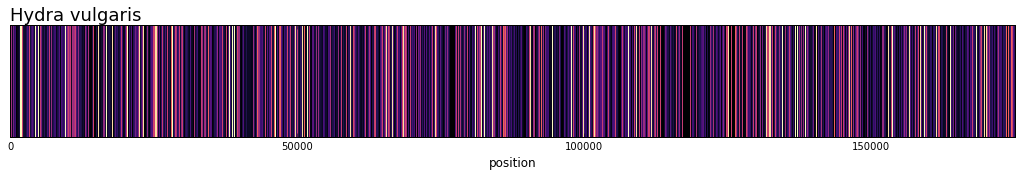

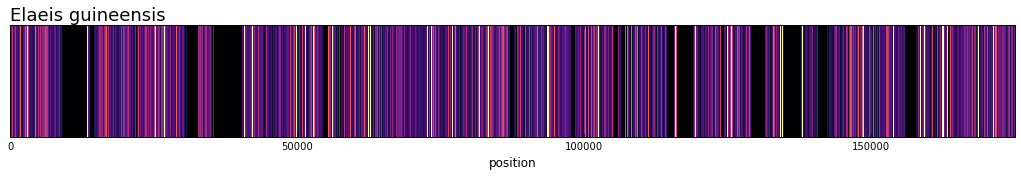

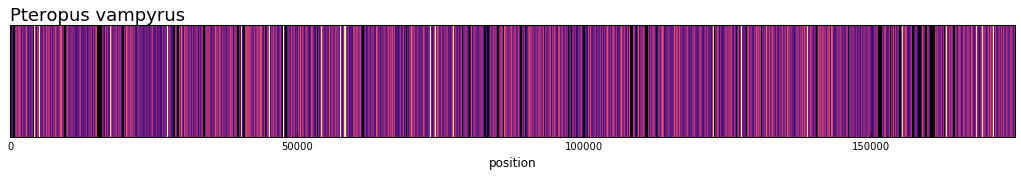

In [27]:
plotFreq(hydra,hydraFreqs[1:])
plotFreq(palm,palmFreqs[1:])
plotFreq(bat,batFreqs[1:])

Wow, each of these has something surprising. For *Hydra*, we see lots of areas of high frequency interspersed in regions of low frequency. There is definitely a rugged topology to this frequency band. Perhaps our clustering algorithms might work better on this data? *Elaeis* is interesting as well. Note the many black bands -- those are the sequences of `N`-repeats we ignored previously. Maybe this genome is separated into clusters by these sequences? If so, our methods might pick them up. *Pteropus* is definitely spread the most evenly. In fact, it looks like most positions on the sequence contain DNA words found at relatively even frequency.

Lucky choices of species to look at! For each species, I'll run $k$-means, SOM, and then plot the original frequency band on top of the cluster bands put out by our two algorithms. That will give a nice visual comparison of what they are accomplishing. I'll keep the parameters consistent. 100-means for $k$-means, 100 nodes, 1000 iterations, and $\gamma$ of 0.0001 for SOMs.

SOM trained 1000 nodes for 1500 iterations.


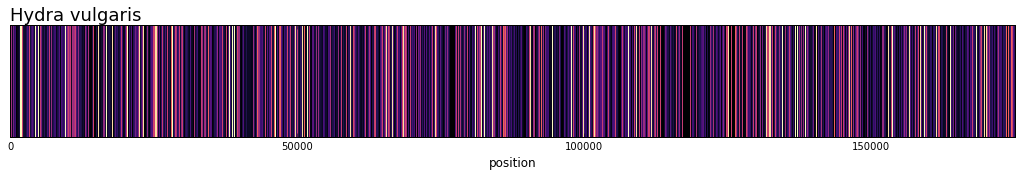

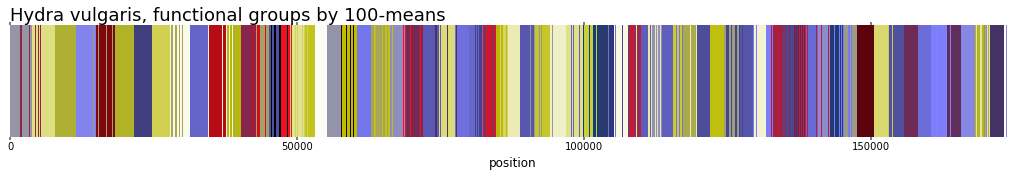

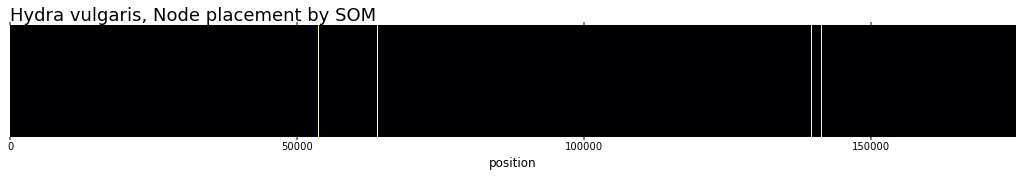

In [28]:
plotFreq(hydra,hydraFreqs[1:])

c,E,closest = kmeans(hydraBand,100,n=15,plot=False)
kMeansBandPlot(closest,100,hydra)

hydraSOM = SOM(hydraBand,nNodes=1000,nIterations=1500,gamma=0.0001)
SOMBandPlot(hydraSOM,hydraBand,hydra)

Now this is very interesting. We definitely have two very different outputs from $k$-means and SOM. $k$-means with $k$=100 seems actually to do very well at picking up on frequency patterns, it's better for high frequencies, and seems to group areas of low frequency together. Just what we want! SOM didn't seem to do so well. Note that these bands have many more position coordinates than above, so the fact that we see any means there must have been clumping at that region. The rest must be spread out.

SOM trained 1000 nodes for 1500 iterations.


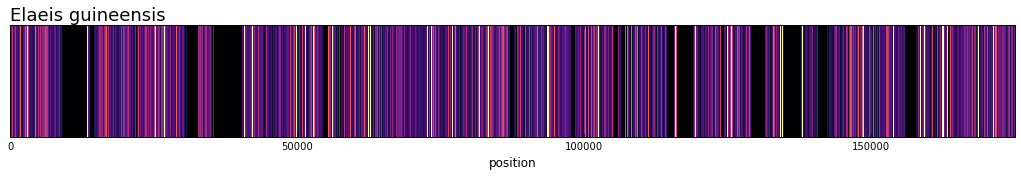

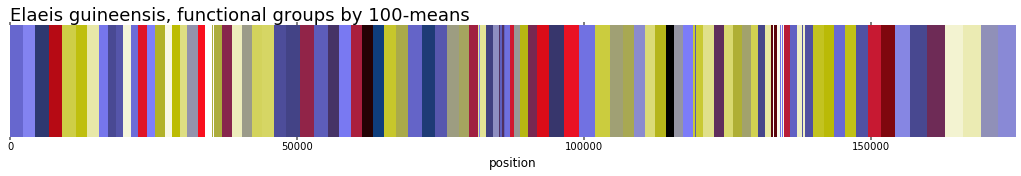

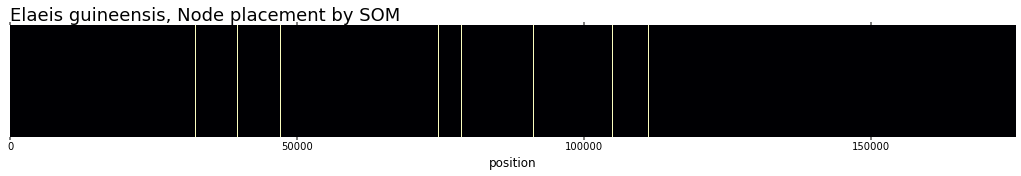

In [29]:
plotFreq(palm,palmFreqs[1:])

c,E,closest = kmeans(palmBand,100,n=15,plot=False)
kMeansBandPlot(closest,100,palm)

palmSOM = SOM(palmBand,nNodes=1000,nIterations=1500,gamma=0.0001)
SOMBandPlot(palmSOM,palmBand,palm)

Wow, hardly *any* of the frequency spikes were picked up by $k$-means on this data compared to hydra above. We're still getting even clustering in the regions where we know nothing is happening. SOMs seem to pick up a few groups, but it's not clear, even visually, what the pattern is that they might be picking up, or if it is just due to random sampling.

SOM trained 1000 nodes for 1500 iterations.


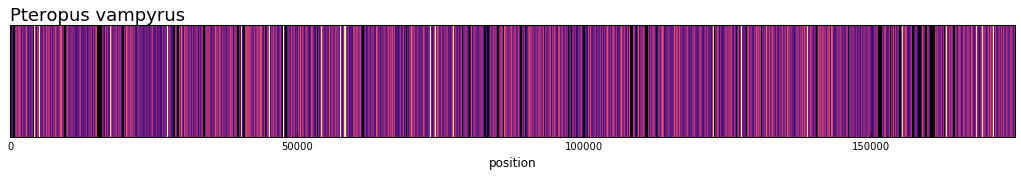

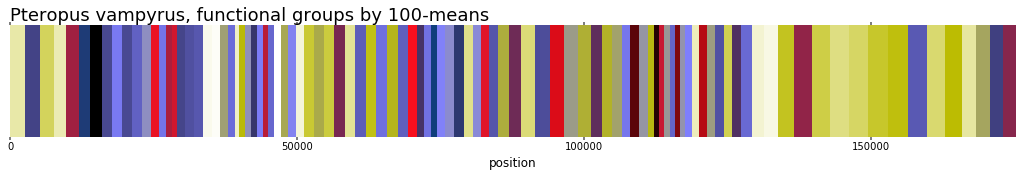

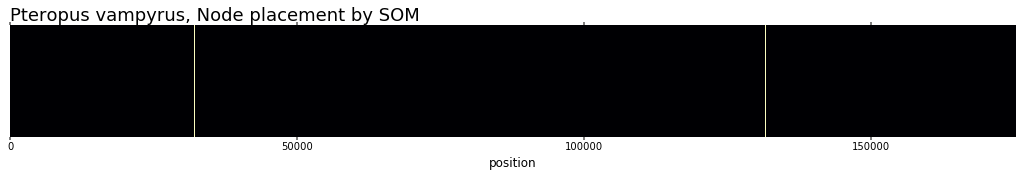

In [30]:
plotFreq(bat,batFreqs[1:])

c,E,closest = kmeans(batBand,100,n=15,plot=False)
kMeansBandPlot(closest,100,bat)

batSOM = SOM(batBand,nNodes=1000,nIterations=1500,gamma=0.0001)
SOMBandPlot(batSOM,batBand,bat)

Hmmm... As I expected, it seems $k$-means is having a harder time with this more evenly-spread bat sequence. It's not picking up any of our frequency spikes. The rest of the cluster spacing is likely due to random initiation. SOMs didn't go so great on this run, but on others there was slight clustering. The fact that it is so variable indicates that it is having a hard time picking out patterns.

Overall, I'm not strongly convinced that either of our algorithms are detecting much pattern in our sequence data. $K$-means might be doing alright on the most variable sequence set we chose, the *Hydra* sequence, but SOMs don't seem to be picking up reliable patterns. It may require much more experimentation with parameters than I was able to accomplish in the timespan of this project to get consistent results. Regardless, let's go back and address one of the major assumptions we have been working with until now.

### Comparison of oligonucleotide lengths

One of the key constraints we have been dealing with so far is the segmentation of sequences into small, even chunks called oligonucleotides, and measuring their respective frequencies. These small sequences are analogous to words in a sentence. Ideally, we would allow the length of these DNA "words" to be learnable as well, but that approach would require computing both the similarity and distance from each DNA "letter" to each other letter in the sequence. When reaching sequence lengths of millions to billions, this approach becomes quickly intractable.

However, our approach is not unreasonable, as oligonucleotides of greater lengths should contain at least some words, or at least fragments of them. If certain words are more frequent than others, these fragments or word-fragment combinations will still show up more frequently than random assemblies of letters.

So, let's see how chopping up the DNA into different oligonucleotide lengths affects the outputs of our clustering algorithms! We'll use the hydra sequence, as that seemed to give the best results for $k$-means, perhaps different oligonucleotide lengths will improve performance of that or SOMs.

In [31]:
oligo3hydra_freq = makeFreqData(hydra,3,printTop=6)
oligo6hydra_freq = makeFreqData(hydra,6,printTop=6)

oligo3hydra_band = freqToSeq(hydra,oligo3hydra_freq)
oligo6hydra_band = freqToSeq(hydra,oligo6hydra_freq)

Sequence chunked into 89 unique oligonucleotides
Seq: TTT | Freq: 15401
Seq: AAA | Freq: 14834
Seq: NNN | Freq: 11721
Seq: ATA | Freq: 9543
Seq: TAT | Freq: 9434
Seq: AAT | Freq: 9315
Sequence chunked into 4140 unique oligonucleotides
Seq: ATATAT | Freq: 1296
Seq: ATATAC | Freq: 66
Seq: ATACAT | Freq: 108
Seq: GCACAA | Freq: 24
Seq: TATTTT | Freq: 383
Seq: TTATCT | Freq: 72


Chopping into trinucleotides generated a sort error, but from my understanding this occurs for very low-frequency items (at least with this data), so what is reported here is probably reliable. Note that the most common oligo is `TTT`, rather than `NNN`! This is not so surprising considering what we noticed above, that this sequence is very rich in `A`'s and `T`'s. It appears that sorting failed again when chopped into hexanucleotides. I wonder what the most frequent six-letter word is in this sequence?

In [32]:
oligo6hydra_freq[np.argmax(oligo6hydra_freq['freq'])]['seq']

array([b'NNNNNN'], 
      dtype='|S6')

The usual culprit, our string of `N`-repeats. Interesting that chopping the sequence into different word lengths generates different sequences that are more frequent. Another observation is that out of all the possible combination of `ATCGN`, not all were used:
* Chopping three ways = $5^3=125$ possible outcomes whereas only 89 were found.
* Chopping six ways = $5^6=15,625$ possible outcomes whereas only 4140 were found. That's only 26% of possible variation!
* I tried chopping 10 ways = $5^{10}=9,765,625$ possible outcomes, but it still wasn't done by the time I got back from lunch, so I decided to spare it.

Let's see how they look.

Top:      Split into 3-nucleotides
Bottom:   Split into 6-nucleotides


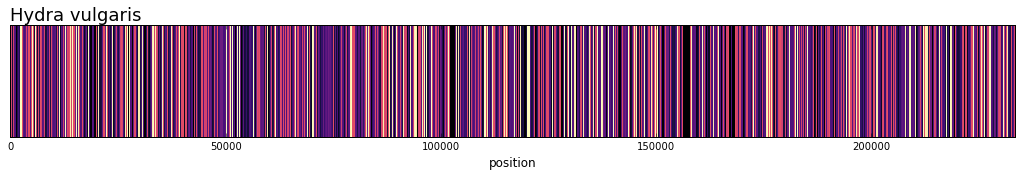

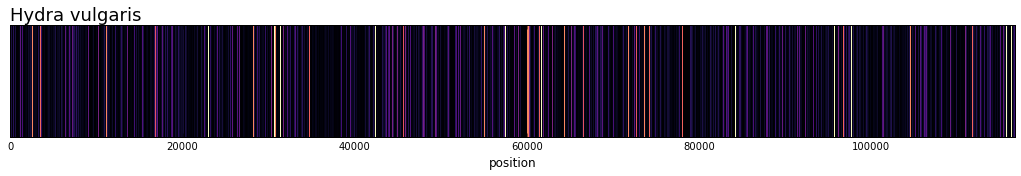

In [33]:
print('Top:      Split into 3-nucleotides')
print('Bottom:   Split into 6-nucleotides')
plotFreq(hydra,oligo3hydra_freq)
plotFreq(hydra,oligo6hydra_freq)

Wow! We have a *completely* different topology based on how we split the sequence. Clearly, splitting into longer sequences gives us more pronounced high-frequency areas. Actually, this is expected, as there are only 89 unique words in the top figure, and twice as many positions available, so we would expect higher counts for more combinations. In the bottom figure, we have expanded into 4140 unique words. If we are taking from the same sequence, it is reasonable that most of those will be infrequent!

Perhaps either of these will be better for our algorithms? Let's try $k$-means and SOMs on each.

SOM trained 1000 nodes for 1500 iterations.


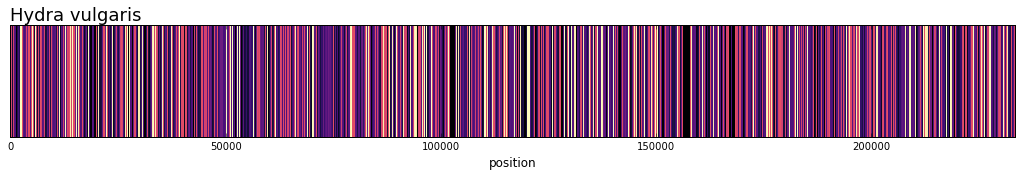

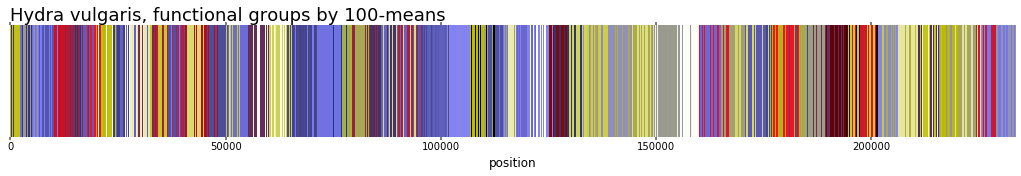

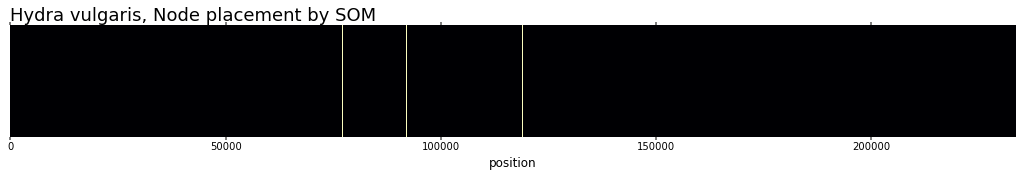

In [34]:
plotFreq(hydra,oligo3hydra_freq)

c,E,closest = kmeans(oligo3hydra_band,100,n=15,plot=False)
kMeansBandPlot(closest,100,hydra)

oli3hydSOM = SOM(oligo3hydra_band,nNodes=1000,nIterations=1500,gamma=0.0001)
SOMBandPlot(oli3hydSOM,oligo3hydra_band,hydra)

Like we saw above, $k$-means seems to do well when the sequence is highly variable. We are picking up the high-frequency regions quite nicely. This is still a bit difficult to interpret, but it seems that the algorithm is at least picking up on patterns in the data. SOMs are still not giving robust results, though it seems it is picking up low areas, around 50k and 175k, but this isn't consistent. Maybe it will do better on our sparser hexanucleotide terrain.

SOM trained 1000 nodes for 1500 iterations.


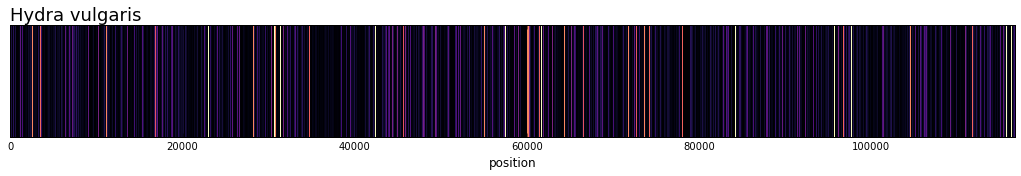

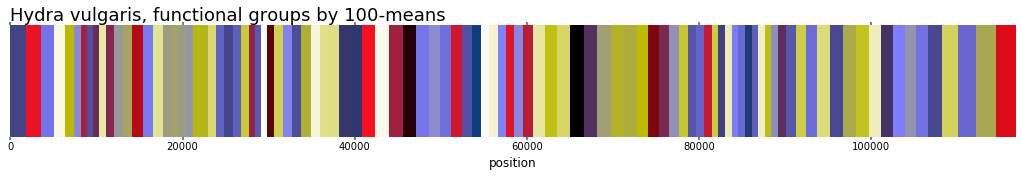

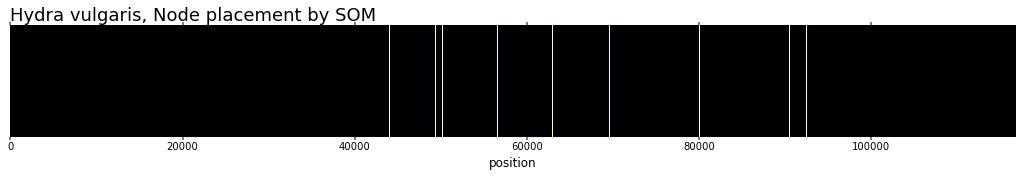

In [35]:
plotFreq(hydra,oligo6hydra_freq)

c,E,closest = kmeans(oligo6hydra_band,100,n=15,plot=False)
kMeansBandPlot(closest,100,hydra)

oli6hydSOM = SOM(oligo6hydra_band,nNodes=1000,nIterations=1500,gamma=0.0001)
SOMBandPlot(oli6hydSOM,oligo6hydra_band,hydra)

It seems again on this sparser data that $k$-means doesn't know what to do, so ends up splitting our band more or less into even chunks. It appears that SOM is targeting this central area where frequencies are a bit higher, but again, results are not robust.

Choosing the best oligonucleotide length may be a tradeoff between too much and too little variability in the sequence. In fact, our original choice of four seemed to be a nice in-between. Let's wrap up our investigation with an interesting application.

### A specific application to human genetic data

Detecting functional genomic elements has direct application to human health. Published on December 31 of last year, gene editing technology (CRISPR-Cas9) restored protein integrity in mice with Duchenne Muscular Dystrophy (DMD; [Nelson et al. 2015](http://science.sciencemag.org/content/early/2015/12/29/science.aad5143)). DMD is caused by a genetic mutation in which individuals do not produce functional copies of the [dystrophin protein](http://www.ncbi.nlm.nih.gov/gene/1756), which is responsible for muscle cell membrane integrity. Humans with this mutation are wheelchair-bound by age 12, and are typically dead by age 25. Essentially, muscle cells are continually degraded everywhere in the body and converted into fat. One in every 5,000 male births is afflicted with DMD, thus understanding the genetic underpinnings of this disease is immensely important. Fortunately, we have a fairly good understanding of the distribution of functional elements within this gene, which is the largest known gene in nature; topping off at about 2.4 million nucleotides. In mice, who have a nearly identical gene and are susceptible to the same mutation, we know that the mutation occurs at a particular coding region of the gene. The researchers were able to excise this short sequence, restoring levels of dystrophin to functional levels.

It is worth pausing to imagine what an impact on human longevity we might accrue if we could predict the behavior of a gene product by the functional breakdown of the gene's sequence elements. Unfortunately, for the remaining 99.92% of the human genome involved in disease, we do not have as extensive a knowledge base of the coding vs. non-coding regions of genes. Using machine learning tools to predict gene structure has massive potential to target functionality, and restore healthy protein production in diseases of genetic origin, particularly in combination with recent advances in high-precision gene-editing technology.

Let's test the ability of our $k$-means and SOM algorithms to detect elements on the human dystrophin gene, which I downloaded from the [NCBI's page](http://www.ncbi.nlm.nih.gov/gene/1756). The gene occurs on the human X chromosome from bases 31119219 to 33339609. To locate coding regions (also called "exons"), I used the first and longest [mRNA transcript](https://www.ncbi.nlm.nih.gov/nuccore/NC_000023.11?report=genbank&from=31119219&to=33339609), `dystrophin transcript variant X2`, which should contain most exons of interest. A more exhaustive analysis should include all transcript variants. A little text manipulation and we can convert the NCBI's mRNA format to a `numpy` array of nucleotide coordinate ranges. 

In [36]:
dysExonRange = np.array([[1,2712],[14884,14976],[27073,27196],[28057,28300],[50225,50383],
    [53130,53195],[54321,54386],[58714,58752],[59451,59587],[61152,61263],
    [63520,63686],[84743,84900],[87364,87449],[90280,90481],[103829,103903],
    [141737,141798],[204380,204440],[229338,229416],[325263,325409],[358888,359156],
    [359765,359885],[377570,377726],[388063,388235],[508455,508644],[538772,538926],
    [560157,560368],[610413,610530],[654742,654974],[700757,700865],[717500,717601],
    [755970,756155],[810378,810527],[812862,813009],[849121,849296],[1097698,1097845],
    [1168311,1168483],[1190864,1191058],[1222882,1223064],[1223916,1224068],
    [1226725,1226862],[1229188,1229310],[1243570,1243740],[1245364,1245492],
    [1245802,1245981],[1261292,1261462],[1267092,1267247],[1270283,1270456],
    [1270853,1270963],[1292534,1292695],[1319023,1319172],[1321962,1322096],
    [1329238,1329420],[1335444,1335614],[1344221,1344376],[1345368,1345481],
    [1349280,1349492],[1352946,1353091],[1365701,1365881],[1372059,1372300],
    [1382537,1382624],[1398790,1398913],[1425941,1426116],[1446484,1446663],
    [1454312,1454419],[1454527,1454628],[1476539,1476658],[1495085,1495235],
    [1524914,1525095],[1525746,1525934],[1578652,1578780],[1579894,1580075],
    [1690275,1690393],[1697250,1697422],[1704077,1704169],[1725565,1725642],
    [1730510,1730602],[1900921,1900982],[2220041,2220150]])

In [37]:
def makeGene(exonRange,pad=0):
    startCoord = 31119219
    endCoord = 33339609
    gene = np.zeros((1,(endCoord-startCoord)))

    for i in exonRange:
        if (i[1]+pad) < gene.shape[1]:
            exon = list(range(i[0],i[1]+pad))
        else:
            exon = list(range(i[0],i[1]))
        for j in exon:
            gene[0][j] = 1
            
    return gene

I've built a frequency band now, just like we've been using, to represent the dystrophin gene. Exons, the sequences that make protein, contain a `1`, and everything else in the gene that is spliced out of the mRNA is coded `0`. There are 78 of them, so I should see 78 stripes in the band below. Let's look at it.

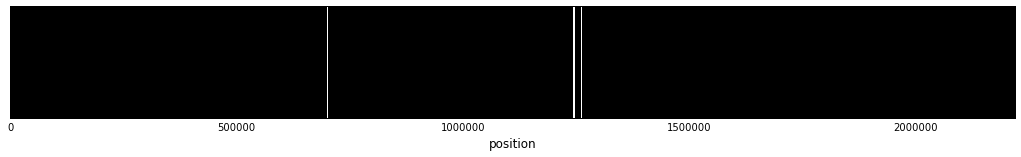

In [38]:
plt.figure(figsize=(18,2))
plt.imshow(makeGene(dysExonRange), cmap='gray', interpolation='nearest', aspect='auto')
ax = plt.axes()
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('position', fontsize=12)

I thought about not showing this, but I had to do it because it illustrates such a beautiful point. This is what they call the "dark matter of the genome". Everything in white up there is the part of the gene that actually *does anything*, the rest is cut out and discarded before the mRNA even leaves the cell nucleus! Notice how *most* of the exons (white stripes) that we defined above *aren't even visible*! This is the nature of our challenge! How can we hope to detect such minute but critically important elements in a sea of `A`'s `T`'s `C`'s and `G`'s? I strongly believe that without robust machine learning tools, we don't stand a chance.

To give our methods some semblance of hope at detecting these regions, I increased the length of each exon by an extra 5000 nucleotides. Check it out now.

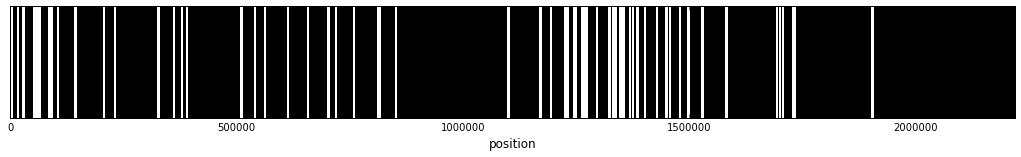

In [39]:
padGene = makeGene(dysExonRange,pad=5000)

plt.figure(figsize=(18,2))
plt.imshow(padGene, cmap='gray', interpolation='nearest', aspect='auto')
ax = plt.axes()
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('position', fontsize=12)

This may give our algorithms some possibility for success. Let's load up the actual sequence data.

In [40]:
dystrophin = loadSeq('humanDystrophin.txt')
dysFreqs = makeFreqData(dystrophin)
dysBand = freqToSeq(dystrophin,dysFreqs)
baseCount(dystrophin)

Sequence loaded:
>gi|568815575:31119219-33339609 Homo sapiens chromosome X, GRCh38.p2 Primary Assembly
Species: Homo sapiens
Sequence chunked into 256 unique oligonucleotides
Sequence length: 2 Mb
Nucleotide counts for Homo sapiens ----
Amount A: 721171
Amount T: 691397
Amount C: 408980
Amount G: 398843


Now the challenge is to map the clusters located by learning the band of sequence frequency, on to this gene represented by an array of zeros and ones. Let's get to work!

In [41]:
dysCenters,dysE,dysClosest = kmeans(dysBand,78,n=15,plot=False)

In [42]:
dysSOM = SOM(dysBand,nNodes=100,nIterations=1500,gamma=0.0001)

SOM trained 100 nodes for 1500 iterations.


Models trained. Let's plot both the cluster centers found by $k$-means, and the node positions of the SOM on the gene itself to visualize where they found patterns.

Red:    k-means cluster center
Green:  SOM node position


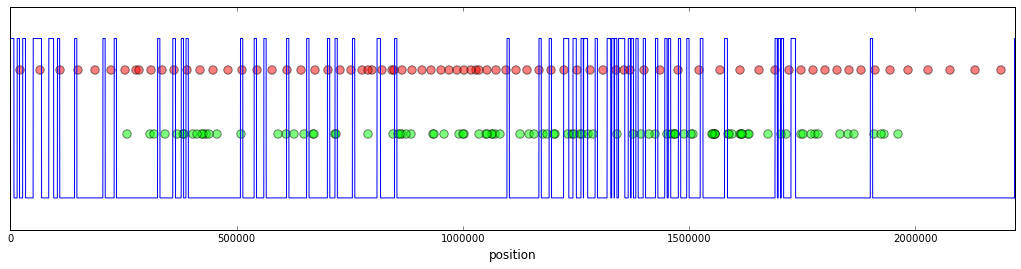

In [43]:
print('Red:    k-means cluster center')
print('Green:  SOM node position')
plt.figure(figsize=(18,4))
plt.plot(padGene[0])
plt.scatter(dysCenters[:,0]*4,np.ones((dysCenters.shape[0]))*0.8,s=70,marker="o",c="red",alpha=0.5)
plt.scatter(dysSOM[:,0]*4,np.ones((dysSOM.shape[0]))*0.4,s=70,marker="o",c="lime",alpha=0.5)
plt.xlim([0,padGene.shape[1]])
ax = plt.axes()
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('position', fontsize=12)

Damn. Not even close. $k$-means doesn't do better than random with these parameters. SOM seemed to pick up on the big desert around position 1M, however, and it seems some of the nodes are close, but it doesn't appear to be better than random. We can quantify this error by seeing how many node positions out of total are within the exon range.

In [44]:
kmeanX = dysCenters[:,0]*4
somX = dysSOM[:,0]*4

# error for kMean
kScore = 0
for i in kmeanX:
    i = int(round(i))
    for j in dysExonRange:
        if i in range(j[0],j[1]):
            kScore+=1
            continue
        else: pass
        
somScore = 0
for i in somX:
    i = int(round(i))
    for j in dysExonRange:
        if i in range(j[0],j[1]):
            somScore+=1
            continue
        else: pass
    

print('kMeans got {:1.4f}% of its cluster centers within an exon.'.format((kScore/kmeanX.shape[0])))
print('SOM got {:1.4f}% of its node positions within an exon.'.format((somScore/somX.shape[0])))

kMeans got 0.0000% of its cluster centers within an exon.
SOM got 0.0000% of its node positions within an exon.


Well, that's discouraging. Before giving up, let's try another parameter set.

*WARNING*: This code takes a while to run, so I commented it out after getting results in case you are running all cells at once.

In [45]:
# dysCenters,dysE,dysClosest = kmeans(dysBand,300,n=15,plot=False)
# dysSOM = SOM(dysBand,nNodes=1500,nIterations=300,gamma=0.001)
# kmeanX = dysCenters[:,0]*4
# somX = dysSOM[:,0]*4

# # error for kMean
# kScore = 0
# for i in kmeanX:
#     i = int(round(i))
#     for j in dysExonRange:
#         if i in range(j[0],j[1]):
#             kScore+=1
#             continue
#         else: pass
        
# somScore = 0
# for i in somX:
#     i = int(round(i))
#     for j in dysExonRange:
#         if i in range(j[0],j[1]):
#             somScore+=1
#             continue
#         else: pass
    
# print()
# print('kMeans got {:1.4f}% of its cluster centers within an exon.'.format((kScore/kmeanX.shape[0])))
# print('SOM got {:1.4f}% of its node positions within an exon.'.format((somScore/somX.shape[0])))

Ok, not so great again, but no worries! In fact, we've kind of rigged the game here a bit. Exons are just one kind of genomic element, and our algorithms are intended to find any kind of pattern in the sequence! So, just because we aren't picking up exons specifically doesn't mean we aren't finding interesting patterns. In fact, it may be regularities in the sequences *outside* the exons that cause them to get chopped out, so really those are the sequences of interest.

Anyway, it was an interesting experiment, but maybe better tools, such as supervised learning methods to learn what sequence types constitute an "exon" combined with clustering afterwards are more appropriate. I suspect that the best machine learning approach to handling sequence data is a combination of tools.

## Conclusions

In the end, I'm not that surprised that a simple application of our algorithms to such complex data as the genome resulted in sub-par clustering. If it had worked marvelously, I might be expecting a Nobel Prize by now! But we certainly learned some interesting things, both about the algorithms and the data, along the way.

For one, DNA sequence data may require some very clever pre-processing before clustering algorithms are applied. Segmenting into frequencies of nucleotide combinations, *i.e.* making a guess at the length of the average DNA "word" may not be the optimal approach. A better approach may be to segment the DNA into much larger (hundreds or thousands) chunks of nucleotides at a time, and apply fine-scale, single-nucleotide clustering to learn *first* what constitutes a DNA word before jumping to whole sentences. For instance, an `A` followed by a `T` may be more likely to be followed by another `AT` than a `GC`. Thus, `ATAT` might constitute a DNA "word". We could run many sequence chunks in parallel to build up a DNA "vocabulary" without specifying before-hand a length constraint for every word. Then, we could apply clustering methods to discover the patterns of these words in the whole genome. But that's a story for another project!

Regarding the algorithms, we witnessed at least one strong weakness of both $k$-means and Self-Organizing Maps when applied to genomic sequences. With $k$-means, we found that having to determine $k$ beforehand forces that many clusters onto the map. At especially high $k$, clustering becomes meaningless as every data point becomes its own cluster. Thus, the tricky bit is determining which choice of $k$ is most appropriate for the question we are asking. The unfortunate paradox is that this is what we are really trying to learn! With SOMs, we found it was similarly difficult to settle on initial parameters, especially in such a data type where clusters are likely driven by very local variation. How many nodes should we start with? How much should each node influence the others? How quickly should the map stabilize? How do we even verify that a node has correctly identified a cluster? There may not be one correct answer to these questions.

In spite of these caveats, machine learning clustering tools have potential to dramatically reshape our understanding of the language of life, the sequence of DNA housed in each of our living cells. While applications range from predicting gene expression patterns to predicting protein function from sequence, these methods may give us one of the most fundamental abilities in all languages: building words from letters, and from words, truly useful ideas.

In [46]:
# Thanks for a great course!